# **Numerical APTOS2019 Dataset Notebook** 
###### _Dataset obtained from: https://www.kaggle.com/datasets/mariaherrerot/aptos2019/data?select=valid.csv_

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from PIL.ExifTags import TAGS
import os
import numpy as np
import cv2
from skimage import io, color
from skimage.feature import local_binary_pattern
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

### Data Exploration:

In [ ]:
# Viewing the first 5 rows of the 'train' csv file

feature_extraction_csv_file_path = os.path.join('..', '..', 'Data', 'APTOS-2019 Dataset', 'feature_extraction_results.csv')

feature_extraction_df = pd.read_csv(feature_extraction_csv_file_path)

feature_extraction_df.head(6)

In [ ]:
# The distrobution of the training data is given below

feature_extraction_df.describe()

In [ ]:
# Determining if there are any null values
feature_extraction_df.info()


In [ ]:
# Check for missing values
print("\nMissing values in each column:")
display(feature_extraction_df.isnull().sum())

In [ ]:
# Check the data types of each column
print("\nData types of each column:")
display(feature_extraction_df.dtypes)

In [ ]:
# Plot histograms for numerical features
print("\nHistograms for numerical features:")
numerical_columns = ['Exudates', 'Oedema', 'Vessel Count', 'Heamotomas', 'Diabetes Status']
feature_extraction_df[numerical_columns].hist(bins=15, figsize=(10, 6), layout=(2, 3))
plt.tight_layout()
plt.show()

In [ ]:
# Plot histograms for each numerical feature, separating by 'Diabetes Status'
print("\nHistograms for numerical features:")

# List of numerical columns (excluding the target column 'Diabetes Status')
numerical_columns = ['Exudates', 'Oedema', 'Vessel Count', 'Heamotomas']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Loop through each numerical column and plot histograms for 'Diabetes Status = 0' and 'Diabetes Status = 1'
for i, col in enumerate(numerical_columns):
    axes[i].hist(
        feature_extraction_df[feature_extraction_df['Diabetes Status'] == 0][col], 
        bins=15, alpha=0.7, label='Non-Diabetic (0)', color='blue'
    )
    axes[i].hist(
        feature_extraction_df[feature_extraction_df['Diabetes Status'] == 1][col], 
        bins=15, alpha=0.7, label='Diabetic (1)', color='orange'
    )
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Plot correlations between features
print("\nCorrelation matrix:")
correlation_matrix = feature_extraction_df[numerical_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Check for class distribution in the target column (e.g., 'Diabetes Status')
print("\nClass distribution of 'Diabetes Status':")
print(feature_extraction_df['Diabetes Status'].value_counts())

In [ ]:
# Visualize the relationship between 'Diabetes Status' and other features
sns.pairplot(feature_extraction_df, hue='Diabetes Status', vars=numerical_columns[:-1])
plt.show()

### Preprocessing:

In [124]:
# Load the dataset (replace 'path_to_your_csv_file.csv' with the actual file path)
#data = os.path.join('..', '..', 'Data', 'APTOS-2019 Dataset', 'feature_extraction_results.csv')
data = os.path.join('..', '..', 'Data', 'APTOS-2019 Dataset', 'high_res_features.csv')

data = pd.read_csv(data)

# Step 2: Separate features (X) and labels (y)
X = data.drop(columns=['Image Name', 'Diabetes Status'])  # Drop 'Image Name' as it's not a useful feature
y = data['Diabetes Status']  # This is the target variable

# Step 3: Split the data into train and test sets (70% train, 30% test)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_val.shape[0]}")


Train set size: 513
Test set size: 221


Standardise Dataset:

In [125]:
# Step 4: Standardize the numerical features
scaler = StandardScaler() 

# Fit the scaler on the training data and transform both the train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Optional: Convert the scaled data back into DataFrame (for readability purposes)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns)

# Display the first few rows of the scaled training data
print("\nScaled training data:")
display(X_train_scaled.head())


Scaled training data:


,Exudates,Oedema,Vessel Count,Heamotomas
0,0.312615,1.799485,1.826815,-0.668109
1,-0.374956,-0.477988,2.513847,1.076410
2,-0.393400,-0.098409,-0.145632,0.339836
3,-0.133716,-0.477988,1.095458,0.378603
4,0.710994,3.697380,-0.588878,-0.687492


Removing Oedema from the standardised dataset:

In [126]:
# Remove the 'Oedema' feature from both the training and validation sets
X_train_scaled = X_train_scaled.drop(columns=['Oedema'])
X_val_scaled = X_val_scaled.drop(columns=['Oedema'])

# Display the first few rows of the updated training data
print("\nTraining data after removing 'Oedema':")
display(X_train_scaled.head())

# Display the first few rows of the updated validation data
print("\nValidation data after removing 'Oedema':")
display(X_val_scaled.head())



Training data after removing 'Oedema':


,Exudates,Vessel Count,Heamotomas
0,0.312615,1.826815,-0.668109
1,-0.374956,2.513847,1.076410
2,-0.393400,-0.145632,0.339836
3,-0.133716,1.095458,0.378603
4,0.710994,-0.588878,-0.687492



Validation data after removing 'Oedema':


,Exudates,Vessel Count,Heamotomas
0,-0.153635,-0.189957,-0.125370
1,0.807637,1.184108,1.871136
2,-0.056254,-0.322931,-0.668109
3,-0.405204,-0.500229,-0.280438
4,-0.326266,-0.588878,-0.668109


Removing Oedema from the Original Dataset:

In [57]:
# Remove the 'Oedema' feature from both the training and validation sets
X_train = X_train.drop(columns=['Oedema'])
X_val = X_val.drop(columns=['Oedema'])

### Machine Learning Models:

##### Reuseable Functions for Plotting Model Statistics:

Function for Plotting Classifier Statistics:

In [127]:
# For tree-based classifiers, plots the confusion matrix, histogram of feature importance and ROC + Precision-Recall Curves

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import numpy as np
import seaborn as sns

def plot_model_evaluation_statistics(model, X_val, y_val):
    # Predict probabilities
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()

    # Feature Importance
    plt.figure(figsize=(6, 4))
    feature_importances = model.feature_importances_
    indices = np.argsort(feature_importances)[::-1] # Sorts feature importances in descending order and get the indices
    feature_names_sorted = X_val.columns[indices]  # Arranges feature names according to the indices

    plt.title('Feature Importances')
    plt.bar(range(X_val.shape[1]), feature_importances[indices], color="r", align="center")
    plt.xticks(range(X_val.shape[1]), feature_names_sorted, rotation=90)
    plt.xlim([-1, X_val.shape[1]])
    plt.show()

In [128]:
# For Linear-based Classifiers, plots the confusion matrix, histogram of feature importance and ROC + Precision-Recall Curves

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import numpy as np
import seaborn as sns

def plot_linear_model_evaluation_statistics(model, X_val, y_val):
    # Predict probabilities
    y_pred_prob = model.predict_proba(X_val)[:, 1]

    # Predict class labels
    y_pred = model.predict(X_val)

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()

    # Coefficients for Linear Model
    if hasattr(model, 'coef_'):
        plt.figure(figsize=(6, 4))
        coefficients = model.coef_[0]
        indices = np.argsort(np.abs(coefficients))[::-1]
        feature_names_sorted = X_val.columns[indices]

        plt.title('Feature Coefficients')
        plt.bar(range(len(indices)), coefficients[indices], color="r", align="center")
        plt.xticks(range(len(indices)), feature_names_sorted, rotation=90)
        plt.xlabel('Features')
        plt.ylabel('Coefficient Value')
        plt.tight_layout()
        plt.show()

Function for Plotting Regressor Statistics:

In [129]:
# Creates the same plots as done for the classifier models, however, also plots the histogram of predictions and uses the cut-off threshold to make predictions binary

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score
import numpy as np
import seaborn as sns

def plot_regression_evaluation_statistics(model, X_val, y_val, cutoff_threshold=0.5):
    # Continuous predictions
    y_pred_continuous = model.predict(X_val)

    # Convert continuous predictions to binary using the cutoff threshold
    y_pred_binary = np.where(y_pred_continuous > cutoff_threshold, 1, 0)

    # Calculate accuracy for the binary predictions
    accuracy = accuracy_score(y_val, y_pred_binary)
    print(f"Validation Accuracy (with cutoff {cutoff_threshold}): {accuracy:.4f}")

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_val, y_pred_binary)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_pred_continuous)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val, y_pred_continuous)

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()

    # Feature Importance (if model supports it - Bayes does not)
    plt.figure(figsize=(6, 4))
    feature_importances = model.feature_importances_
    indices = np.argsort(feature_importances)[::-1]
    feature_names_sorted = X_val.columns[indices]

    plt.title('Feature Importances')
    plt.bar(range(X_val.shape[1]), feature_importances[indices], color="r", align="center")
    plt.xticks(range(X_val.shape[1]), feature_names_sorted, rotation=90)
    plt.xlim([-1, X_val.shape[1]])
    plt.show()

Function for Plotting Neural Network Statistics: 

In [130]:
# Creates the confusion matrix, ROC + Area Under Curve graph, precision-recall curve as well as the loss and accuracy graphs as epochs increase.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
import numpy as np

def analyze_neural_network_performance(model, X_train, y_train, X_val, y_val, history=None):
    # Predict probabilities for the validation set
    y_pred_prob = model.predict(X_val).squeeze()
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    # Classification Report
    print(classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1']))

    # Training Process: Loss and Accuracy
    if history is not None:
        # Plot training & validation accuracy values
        plt.figure(figsize=(6, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper left')
        plt.tight_layout()
        plt.show()

#### 1. Logistic Regression:

Training the Model:

In [136]:
# Creating a logistic regression model and testing it's accuracy on the validation data

model = LogisticRegression(max_iter=1000) # instantiate the model

#model.fit(X_train, y_train) # fitting the model on the training set
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_val_scaled) # making predictions on the validation set

accuracy = accuracy_score(y_val, y_pred) # calculate the accuracy of the model
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.6968


Hyperparameter Tuning using Optuna:

In [137]:
# Objective function to optimize with Optuna
def objective(trial):
    # Suggest values for hyperparameters
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs'])
    C = trial.suggest_float('C', 1e-6, 1e3, log=True)  # Regularization strength
    max_iter = trial.suggest_int('max_iter', 100, 2000)
    
    # Create the Logistic Regression model with suggested hyperparameters
    model = LogisticRegression(solver=solver, C=C, max_iter=max_iter, random_state=42)
    
    # Perform cross-validation to get an evaluation score
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    
    return score

# Create the Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

# Output the best hyperparameters found by Optuna
print("Best hyperparameters:")
print(study.best_params)

# Train the Logistic Regression model using the best hyperparameters
best_params = study.best_params
best_model = LogisticRegression(**best_params, random_state=42)
best_model.fit(X_train_scaled, y_train)

# Make predictions on the validation set
y_val_pred = best_model.predict(X_val_scaled)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy with tuned hyperparameters: {accuracy:.4f}")

[I 2024-09-30 23:27:22,119] A new study created in memory with name: no-name-3f712df6-7fe7-42cd-99b8-093fe26b5bf9
[I 2024-09-30 23:27:22,159] Trial 0 finished with value: 0.6394441271654292 and parameters: {'solver': 'liblinear', 'C': 0.0779990794320917, 'max_iter': 1941}. Best is trial 0 with value: 0.6394441271654292.
[I 2024-09-30 23:27:22,199] Trial 1 finished with value: 0.6374643061107939 and parameters: {'solver': 'liblinear', 'C': 3.316381666303669e-05, 'max_iter': 1442}. Best is trial 0 with value: 0.6394441271654292.
[I 2024-09-30 23:27:22,255] Trial 2 finished with value: 0.5536074624024367 and parameters: {'solver': 'lbfgs', 'C': 3.300009148214161e-05, 'max_iter': 1582}. Best is trial 0 with value: 0.6394441271654292.
[I 2024-09-30 23:27:22,283] Trial 3 finished with value: 0.6335808109651627 and parameters: {'solver': 'liblinear', 'C': 0.001130623712399001, 'max_iter': 1433}. Best is trial 0 with value: 0.6394441271654292.
[I 2024-09-30 23:27:22,322] Trial 4 finished with 

Best hyperparameters:
{'solver': 'saga', 'C': 0.14473810132433815, 'max_iter': 705}
Validation Accuracy with tuned hyperparameters: 0.6878


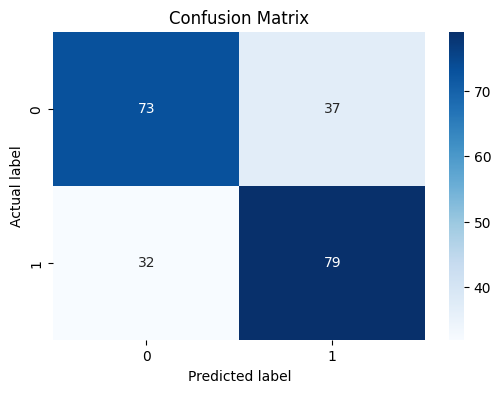

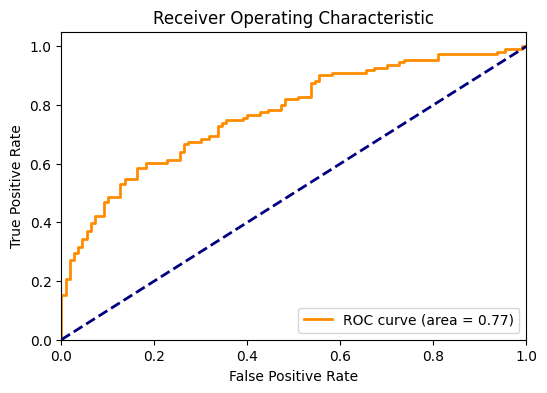

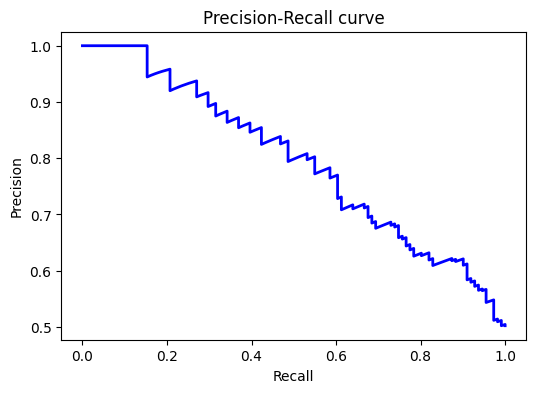

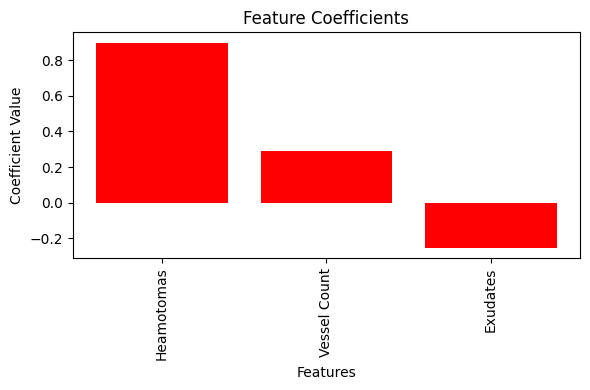

In [139]:
plot_linear_model_evaluation_statistics(best_model, X_val_scaled, y_val)

#### 2. Random Forrest:

##### 2.1 Randdom Forrest Classifier: 

Training the Model:

In [140]:
# Creating a random forest model and testing it's accuracy on the validation data

random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=42)  # n_estimators is the number of trees

random_forest_model.fit(X_train_scaled, y_train)

y_pred = random_forest_model.predict(X_val_scaled)

accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.6923


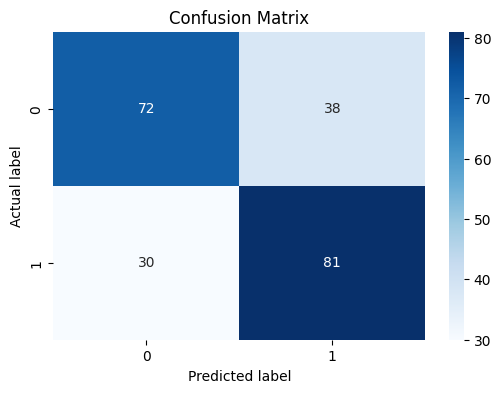

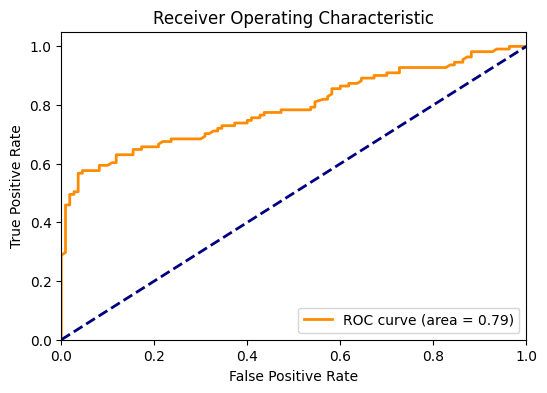

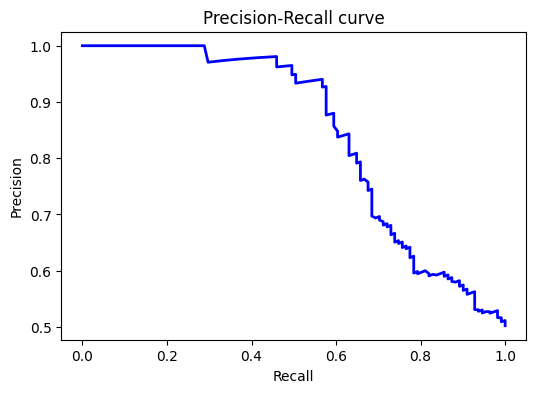

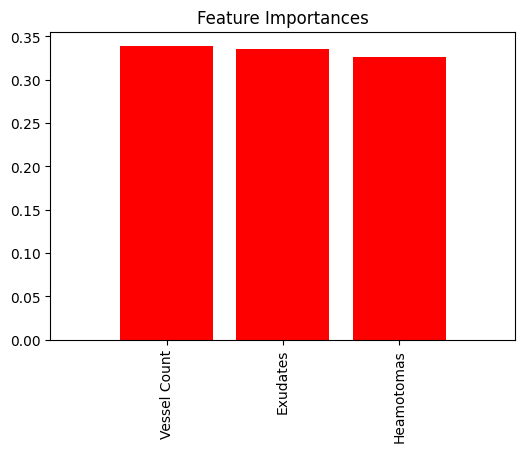

In [141]:
plot_model_evaluation_statistics(random_forest_model, X_val_scaled, y_val)

##### 2.2 Random Forrest Regressor with Cutoff:

In [142]:
# Initialise random forrest regressor
randForest_regressor = RandomForestRegressor(n_estimators=1000, random_state=42)

# Train the model
randForest_regressor.fit(X_train_scaled, y_train)

# Predict on validation data
y_pred = randForest_regressor.predict(X_val_scaled)

# Calculate RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Validation RMSE: {rmse:.4f}")

# Calculate R^2 score
r2_score = randForest_regressor.score(X_val_scaled, y_val)
print(f"Validation R^2 Score: {r2_score:.4f}")

Validation RMSE: 0.4403
Validation R^2 Score: 0.2244


c:\Users\Kaylin\OneDrive\Documents\Fourth Year IE 2024\Investigation Project\ELEN4012A-Investigation-Project\InvestigationEnv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Hyperparameter Tuning using Optuna:

In [143]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Objective function for Optuna to minimize
def objective(trial):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    # Create the RandomForestRegressor model with suggested hyperparameters
    randForest_regressor = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    # Perform cross-validation (you can adjust `cv` for more or fewer folds)
    score = cross_val_score(randForest_regressor, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

    # Return the negative RMSE (because Optuna maximizes by default)
    return score

# Create the Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Output the best hyperparameters found by Optuna
print("Best hyperparameters:")
print(study.best_params)

# Train the RandomForestRegressor model using the best hyperparameters
best_params = study.best_params
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train_scaled, y_train)

# Predict on the validation set
y_val_pred = best_model.predict(X_val_scaled)

# Calculate RMSE on the validation set
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print(f"Validation RMSE with tuned hyperparameters: {rmse:.4f}")

# Calculate R² score
r2_score = best_model.score(X_val_scaled, y_val)
print(f"Validation R² Score with tuned hyperparameters: {r2_score:.4f}")


[I 2024-09-30 23:32:01,016] A new study created in memory with name: no-name-7adadae0-17e3-4775-99c5-c90f8e1aff17
[I 2024-09-30 23:32:05,280] Trial 0 finished with value: -0.435573795833622 and parameters: {'n_estimators': 688, 'max_depth': 28, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: -0.435573795833622.
[I 2024-09-30 23:32:10,379] Trial 1 finished with value: -0.43685839622281764 and parameters: {'n_estimators': 503, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 1 with value: -0.43685839622281764.
[I 2024-09-30 23:32:15,183] Trial 2 finished with value: -0.4351445817060468 and parameters: {'n_estimators': 442, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 1 with value: -0.43685839622281764.
[I 2024-09-30 23:32:19,808] Trial 3 finished with value: -0.44070664541395876 and parameters: {'n_estimators': 436, 'max_depth': 

Best hyperparameters:
{'n_estimators': 318, 'max_depth': 2, 'min_samples_split': 12, 'min_samples_leaf': 16, 'max_features': None}
Validation RMSE with tuned hyperparameters: 0.4448
Validation R² Score with tuned hyperparameters: 0.2087


c:\Users\Kaylin\OneDrive\Documents\Fourth Year IE 2024\Investigation Project\ELEN4012A-Investigation-Project\InvestigationEnv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Plot the Predictions to Understand the Binary Clustering and Cutoff Point:

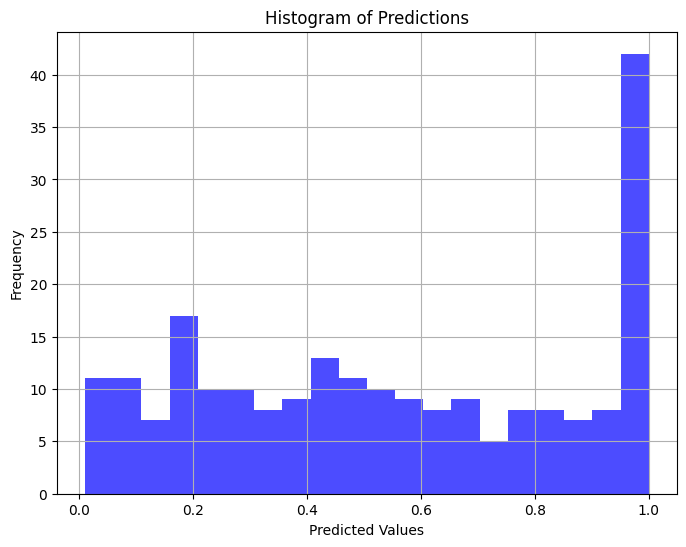

In [144]:
# Plot histogram of predictions
plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=20, color='blue', alpha=0.7)
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.title('Histogram of Predictions')
plt.grid(True)
plt.show()

In [145]:
cutoff_threshold_val = np.median(y_pred)
print(cutoff_threshold_val)

0.512


In [146]:
binary_predictions = np.where(y_pred > cutoff_threshold_val, 1, 0)

Validation Accuracy (with cutoff 0.512): 0.7149


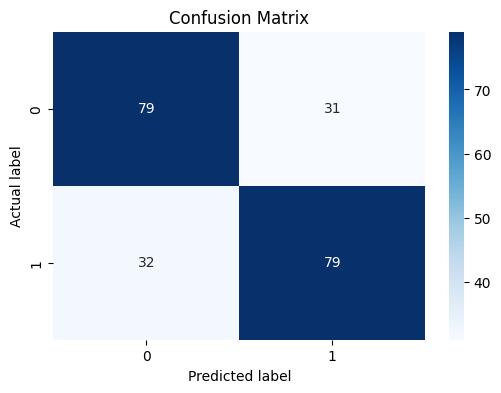

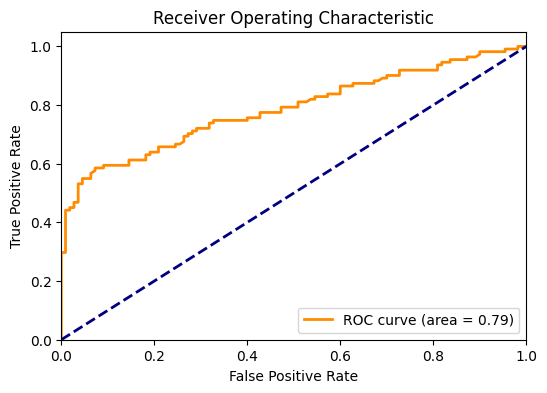

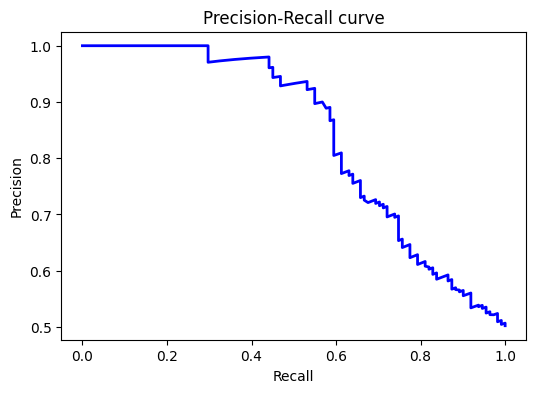

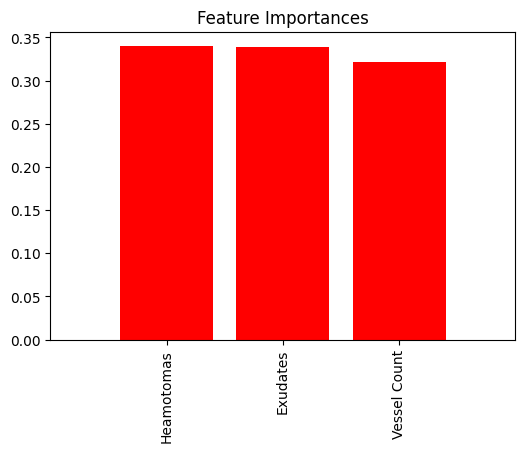

In [147]:
plot_regression_evaluation_statistics(randForest_regressor, X_val_scaled, y_val, cutoff_threshold=cutoff_threshold_val)

#### 3. Naive Bayes:

##### 3.1 Multinomial Naive Bayes:

Training the Model:

In [149]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the model
mnb = MultinomialNB()

# Train the model
mnb.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = mnb.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.6154


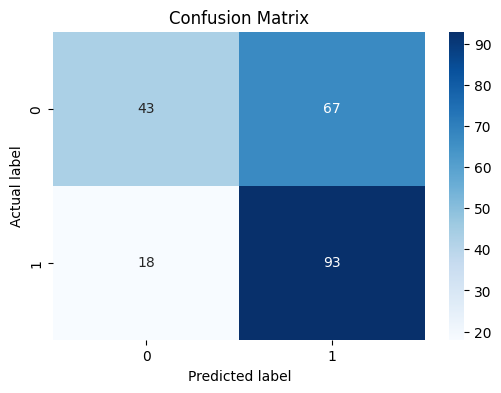

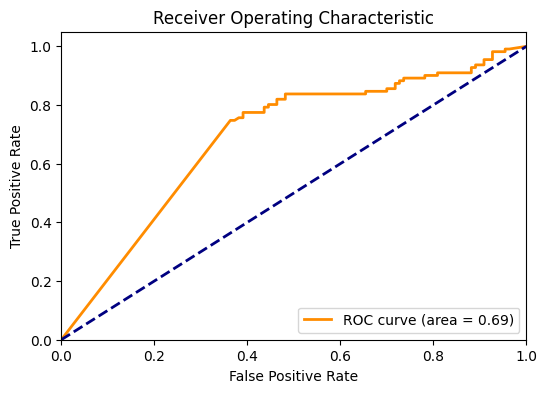

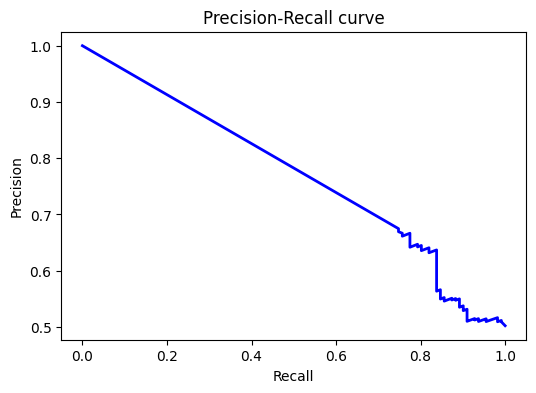

In [151]:
plot_linear_model_evaluation_statistics(mnb, X_val, y_val)

##### 3.2 Gaussian Naive Bayes:

Training the Model:

In [150]:
from sklearn.naive_bayes import GaussianNB

# Train the Naive Bayes model on the training set
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train_scaled, y_train)

# Make predictions on testing data set
y_pred = naive_bayes_model.predict(X_val_scaled)

# Find the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.7149


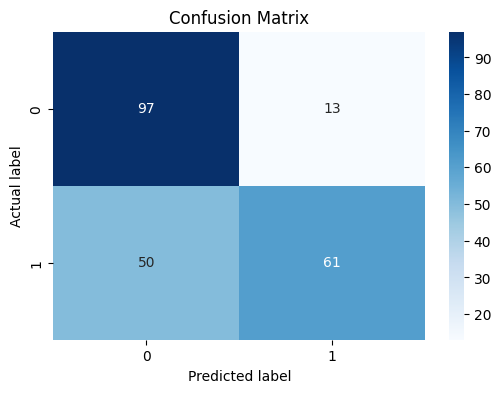

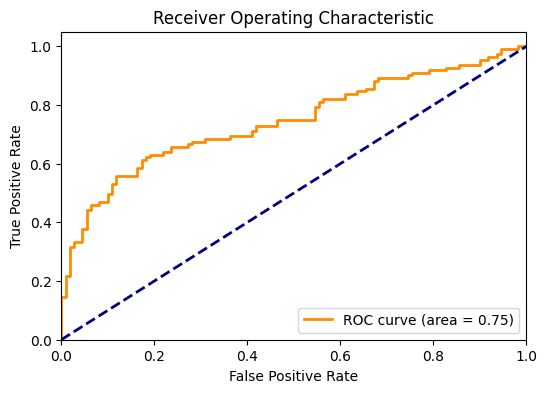

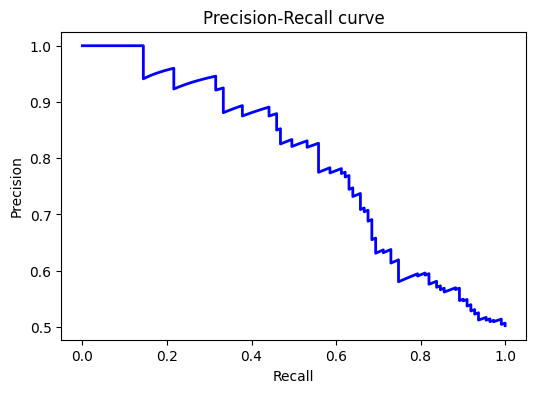

In [152]:
plot_linear_model_evaluation_statistics(naive_bayes_model, X_val_scaled, y_val)

#### 4. XGBoost:

##### 4.1 XGBoost Classifier:

Training the Model:

In [155]:
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier()

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Predict on validation data
y_pred = xgb_model.predict(X_val_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.6516


Hyper-parameter Tuning using Optuna:

In [158]:
import optuna
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Objective function for Optuna to minimize
def objective(trial):
    # Suggest values for hyperparameters
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',  # Assuming binary classification
        'eval_metric': 'logloss',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    # Create the XGBoost model with suggested hyperparameters
    xgb_model = xgb.XGBClassifier(**param, use_label_encoder=False)

    # Perform cross-validation
    score = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()

    return score

# Create the Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Output the best hyperparameters found by Optuna
print("Best hyperparameters:")
print(study.best_params)

# Train the XGBoost model using the best hyperparameters
best_params = study.best_params
xgb_best_model = xgb.XGBClassifier(**best_params, use_label_encoder=False)
xgb_best_model.fit(X_train_scaled, y_train)

# Predict on the validation set
y_val_pred = xgb_best_model.predict(X_val_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy with tuned hyperparameters: {accuracy:.4f}")

[I 2024-10-01 00:17:07,946] A new study created in memory with name: no-name-ec7cc6df-cdd8-427c-8a18-b1219d7e8823
[I 2024-10-01 00:17:08,486] Trial 0 finished with value: 0.6901008947268228 and parameters: {'booster': 'gbtree', 'lambda': 0.376406148549112, 'alpha': 0.006059908247890127, 'learning_rate': 0.21999369570474925, 'n_estimators': 207, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.28979053720179426, 'subsample': 0.9679412800201743, 'colsample_bytree': 0.824366526856936}. Best is trial 0 with value: 0.6901008947268228.
[I 2024-10-01 00:17:10,131] Trial 1 finished with value: 0.6589758233390445 and parameters: {'booster': 'gbtree', 'lambda': 1.012377167663672e-05, 'alpha': 3.187800425183512e-06, 'learning_rate': 0.2857503407696617, 'n_estimators': 513, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.3350296494981111, 'subsample': 0.6742731118108269, 'colsample_bytree': 0.9952363254507987}. Best is trial 0 with value: 0.6901008947268228.
[I 2024-10-01 00:18:39,084] Trial 2 

Best hyperparameters:
{'booster': 'dart', 'lambda': 5.358178572072338e-06, 'alpha': 2.5168136193363836e-07, 'learning_rate': 0.025321306560073416, 'n_estimators': 290, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 0.5610546974787439, 'subsample': 0.6943609932897619, 'colsample_bytree': 0.9375236748735898}
Validation Accuracy with tuned hyperparameters: 0.7149


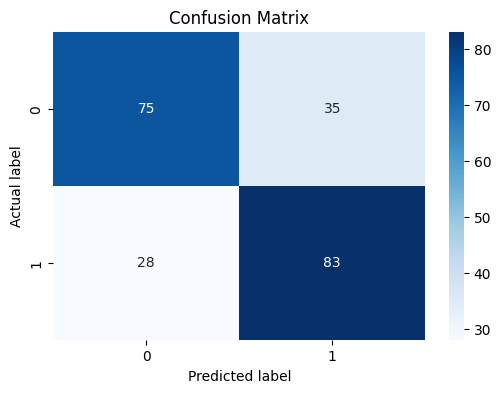

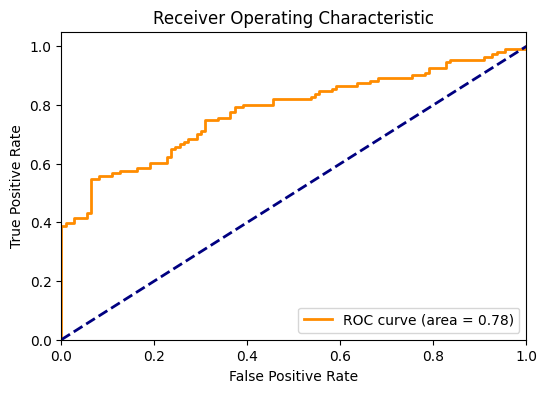

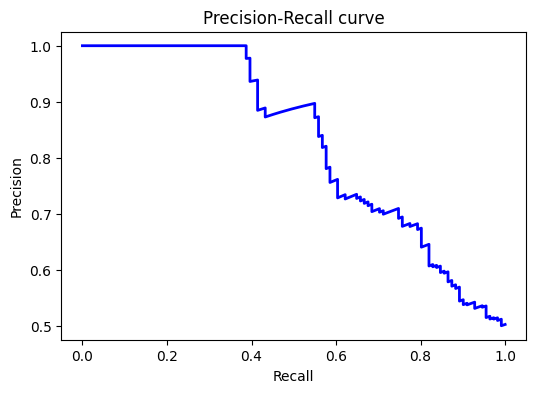

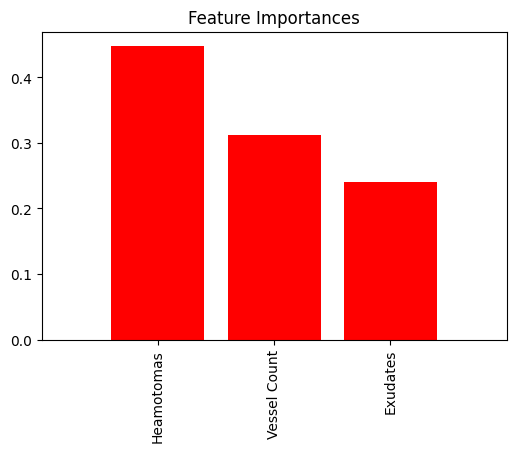

In [159]:
plot_model_evaluation_statistics(xgb_best_model, X_val_scaled, y_val)

#### 2. SVM Model with rbg kernel:

In [ ]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Create the SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Step 2: Train the model on the scaled training data
svm_model.fit(X_train_scaled, y_train)

# Step 3: Make predictions on the validation set
y_val_pred = svm_model.predict(X_val_scaled)

# Step 4: Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Step 5: Print a classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Step 6: Plot a confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

#### 1.2. SVM with Linear Kernel:

In [ ]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 1: Create the SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Step 2: Train the model on the scaled training data
svm_model.fit(X_train_scaled, y_train)

# Step 3: Make predictions on the validation set
y_val_pred = svm_model.predict(X_val_scaled)

# Step 4: Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Step 5: Print a classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Step 6: Plot a confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Step 7: Extract and plot feature importance for the linear SVM
# Extract the feature importance (absolute value of the coefficients)
feature_importance = np.abs(svm_model.coef_).flatten()

# Create a DataFrame to hold feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Step 8: Plot the feature importance
plt.figure(figsize=(6, 4))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in SVM (Linear Kernel)')
plt.gca().invert_yaxis()  # Most important feature at the top
plt.show()

